In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
YEAR = 2021

In [3]:
def read_file(year):
    PATH = f'../dataset/imbank_customer_data/iMBANK_CUSTOMER_DATA_{year}(K-DigitalTraining).csv'
    df = pd.read_csv(PATH, encoding='euc-kr', usecols=['기준년월', '고객ID', '연령대'])
    df = df.sort_values(by='기준년월', ascending=True).reset_index(drop=True)
    return df

CS = read_file(YEAR)

In [4]:
def read_file1(year):
    PATH = f'../dataset/imbank_card_data/iMBANK_CARD_DATA_{year}(K-DigitalTraining).csv'
    df = pd.read_csv(PATH, encoding='euc-kr', usecols=['거래년월', '고객ID'])
    df = df.sort_values(by='거래년월', ascending=True).reset_index(drop=True)
    return df
C = read_file1(YEAR)

In [5]:
# 거래년월이 202212 이전인 데이터 필터링 -> 12월 안가져가도 되나???? 
filtered_data = C[C['거래년월'] < int(f"{YEAR}12")]

# 마지막 거래년월 찾기
last_transaction = filtered_data.groupby('고객ID')['거래년월'].max().reset_index()
last_transaction.columns = ['고객ID', '마지막 거래년월']
last_transaction.tail()

,고객ID,마지막 거래년월
760613,9999918728,202111
760614,9999933174,202109
760615,9999972286,202101
760616,9999981183,202111
760617,9999998161,202111


In [6]:
# 고객ID 기준 Data_frame merge
merge_card = pd.merge(C, last_transaction, on='고객ID', how='inner')
merge_card.tail(15)

,거래년월,고객ID,마지막 거래년월
60641694,202112,3177078879,202111
60641695,202112,3205011838,202111
60641696,202112,3055061788,202111
60641697,202112,2931907302,202111
60641698,202112,2950007638,202111
60641699,202112,2914424833,202111
60641700,202112,4116127380,202111
60641701,202112,9580341295,202111
60641702,202112,9444540701,202111
60641703,202112,7938809932,202111


In [7]:
merge_card.shape

(60641709, 3)

In [8]:
# 거래이후 소요시간 계산 
current_year_month = int(f'{YEAR}11')
merge_card['거래이후소요기간'] = ((current_year_month // 100 - merge_card['마지막 거래년월'] // 100) * 12 +
                                        (current_year_month % 100 - merge_card['마지막 거래년월'] % 100))

In [9]:
# 거래년월 컬럼 삭제 
new_card = merge_card.drop(columns=['거래년월'])

In [10]:
#마지막컬럼 남기고 중복 제거 -> 거래이후소요기간은 동일 값이라 정렬 필요 없음
new_card = new_card.drop_duplicates(subset='고객ID', keep='last').reset_index(drop=True)
new_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760618 entries, 0 to 760617
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   고객ID      760618 non-null  int64
 1   마지막 거래년월  760618 non-null  int64
 2   거래이후소요기간  760618 non-null  int64
dtypes: int64(3)
memory usage: 17.4 MB


In [69]:
new_card.shape

(736496, 3)

In [11]:
# 이탈 여부 판단
new_card['이탈여부'] = np.where(new_card['거래이후소요기간'] > 1,'이탈', '유지')

In [12]:
new_card.groupby(['이탈여부']).count()

,고객ID,마지막 거래년월,거래이후소요기간
이탈여부,,,
유지,614897,614897,614897
이탈,145721,145721,145721


In [13]:
# CS 데이터 기준년월컬럼 삭제 및 고객ID 중복 거거
CS = CS.drop(columns='기준년월')

In [20]:
# card_2023 & CS_2023 merge
last = new_card.merge(CS, on=['고객ID'], how='inner')

# 고객 ID 중복 제거
last = last.drop_duplicates(subset='고객ID', keep='last').reset_index(drop=True)
last.head()

,고객ID,마지막 거래년월,거래이후소요기간,이탈여부,연령대
0,5558279370,202101,10,이탈,30대
1,5971116803,202101,10,이탈,40대
2,3152683788,202101,10,이탈,50대
3,9812943452,202101,10,이탈,60대이상
4,4665400531,202101,10,이탈,20대


In [72]:
last.shape

(736496, 5)

In [15]:
# 서머리 결과 DF 형태로 저장
summary = pd.DataFrame(last.groupby(['이탈여부','연령대'])['고객ID'].count())
summary = summary.reset_index()

In [16]:
# 유지와 이탈 고객의 전체 수
total유지 = summary[summary['이탈여부'] == '유지']['고객ID'].sum()
total이탈 = summary[summary['이탈여부'] == '이탈']['고객ID'].sum()

# 비율 계산
summary['비율'] = summary.apply(lambda row: row['고객ID'] / total유지 if row['이탈여부'] == '유지' else
                      (row['고객ID'] / total이탈 if row['이탈여부'] == '이탈' else 0), axis=1)

# 결과 출력
summary

,이탈여부,연령대,고객ID,비율
0,유지,10대미만,31139,0.051355
1,유지,20대,96452,0.159071
2,유지,30대,82866,0.136664
3,유지,40대,112408,0.185386
4,유지,50대,138473,0.228373
5,유지,60대이상,145009,0.239152
6,이탈,10대미만,6396,0.044288
7,이탈,20대,29321,0.203029
8,이탈,30대,24527,0.169833
9,이탈,40대,28745,0.199040


In [52]:
# 중복 확인
dupl = summary['고객ID'].duplicated().any()
if dupl:
    print('중복')
else:
    print('중복아님')

중복아님


In [53]:
# 시각화 그리기 한글폰트 가가
plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='white')

In [84]:
last

,고객ID,마지막 거래년월,거래이후소요기간,이탈여부,연령대
0,9902238082,202301.0,10.0,이탈,60대이상
1,3591992975,202301.0,10.0,이탈,40대
2,3730210895,202301.0,10.0,이탈,20대
3,8896478537,202301.0,10.0,이탈,30대
4,8063560249,202301.0,10.0,이탈,30대
...,...,...,...,...,...
736491,5996611034,202311.0,0.0,유지,50대
736492,5791291255,202311.0,0.0,유지,60대이상
736493,3557388137,202311.0,0.0,유지,20대
736494,9675608397,202311.0,0.0,유지,60대이상


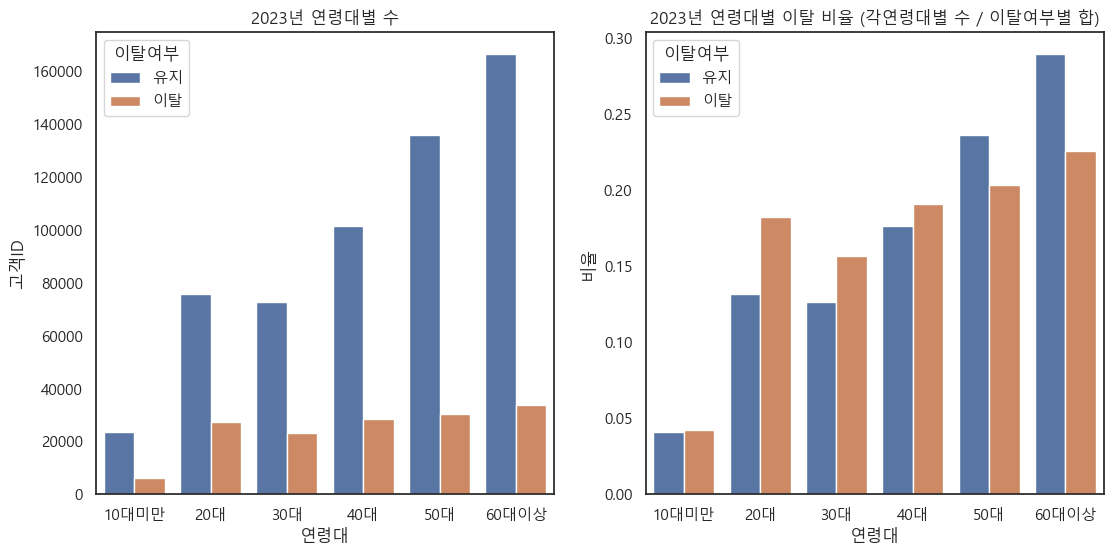

In [82]:
fig, ax = plt.subplots(figsize = (13,6), ncols=2)
sns.barplot(summary, x='연령대', y = '고객ID', hue='이탈여부', ax=ax[0])
sns.barplot(summary, x='연령대', y = '비율', hue='이탈여부', ax=ax[1])

ax[0].set_title(f'{YEAR}년 연령대별 수', )
ax[1].set_title(f'{YEAR}년 연령대별 이탈 비율 (각연령대별 수 / 이탈여부별 합)')
plt.show()

In [22]:
last.to_csv(f'../dataset/summary_{YEAR}.csv', index=False, encoding="utf-8-sig")